In [1]:
# importing required libraries, modules and pretrained model 

import os
import tensorflow as tf
from tensorflow import keras
from skimage import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception


SEED = 42
SIZE = (224, 224)
BATCH_SIZE = 32

pd.set_option('display.max_rows', None)

In [2]:
# training and validation data

from google.colab import files
uploaded = files.upload()

Saving horse breeds.csv to horse breeds (1).csv


In [3]:
import io
labels = pd.read_csv(io.BytesIO(uploaded['horse breeds.csv']))

In [4]:
labels.head()

,id,breed
0,01_016,Akhal-Teke
1,01_017,Akhal-Teke
2,01_018,Akhal-Teke
3,01_019,Akhal-Teke
4,01_020,Akhal-Teke


In [5]:
labels['id'] = labels['id'].apply(lambda x: x + '.png')
labels.head()

,id,breed
0,01_016.png,Akhal-Teke
1,01_017.png,Akhal-Teke
2,01_018.png,Akhal-Teke
3,01_019.png,Akhal-Teke
4,01_020.png,Akhal-Teke


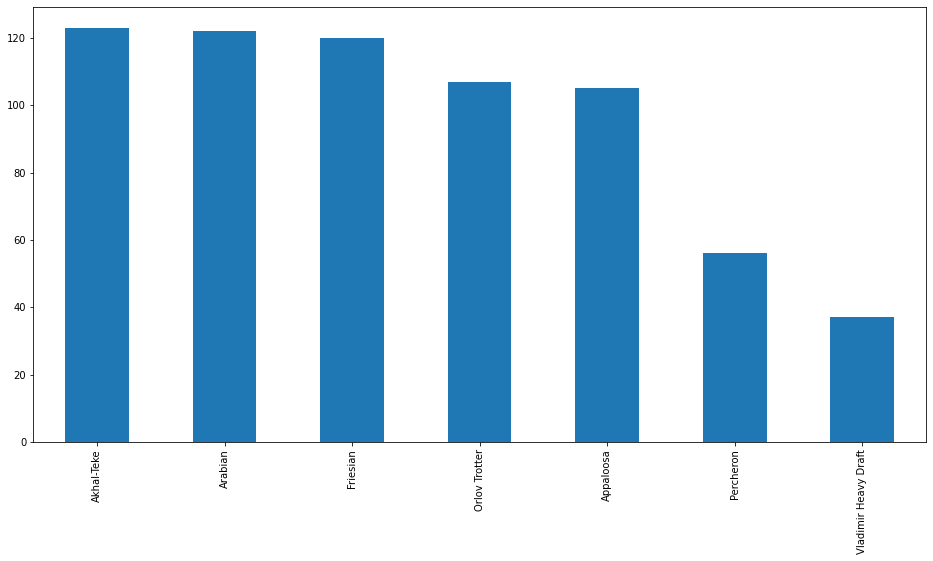

In [6]:
labels['breed'].value_counts().plot.bar(figsize=(16, 8))

In [7]:
# ImageDatagenerator to load the images in batches and perform data augmentation

data_generator = ImageDataGenerator(rescale= 1./255, validation_split=0.2, rotation_range=20,
                                    zoom_range=0.1, width_shift_range=0.2, height_shift_range=0.2,
                                    shear_range=0.1, horizontal_flip=True, fill_mode="nearest")

In [11]:
train_generator = data_generator.flow_from_dataframe(labels, directory='/content/Images', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='training')
val_generator = data_generator.flow_from_dataframe(labels, directory='/content/Images', x_col='id', y_col='breed', target_size=SIZE, class_mode='categorical', batch_size=BATCH_SIZE, shuffle=True, seed=SEED, subset='validation')

Found 536 validated image filenames belonging to 7 classes.
Found 134 validated image filenames belonging to 7 classes.


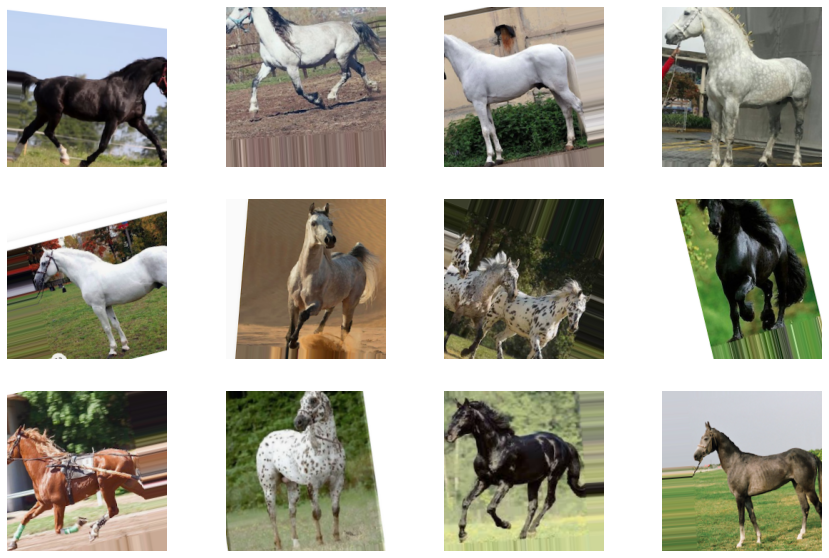

In [12]:
# 12 images after augmentation

img, label = next(train_generator)

fig = plt.figure(figsize=(15, 10))

for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(img[i])
    plt.axis('off')

In [13]:
# callbacks that will be used during training

early_stopping = EarlyStopping(monitor='val_loss', mode = 'min', patience=10)
checkpoint = ModelCheckpoint(filepath = './weights.hdf5', verbose=1, save_best_only=True)\

In [14]:
base_model = Xception(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

base_model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

In [15]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
head_model = AveragePooling2D(pool_size=(4, 4))(base_model.output)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(1024, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(512, activation='relu')(head_model)
head_model = Dropout(0.3)(head_model)
head_model = Dense(7, activation='softmax')(head_model)

In [24]:
model = Model(inputs=base_model.input, outputs=head_model)
optimizer = SGD(learning_rate=0.1, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['categorical_accuracy'])

In [25]:
#first cycle

history1 = model.fit(train_generator, epochs=5, callbacks=[checkpoint], validation_data=val_generator)

Epoch 1/5
17/17 [==============================] - ETA: 0s - loss: 2.1739 - accuracy: 0.3638
Epoch 1: val_loss improved from inf to 2.50501, saving model to ./weights.hdf5
17/17 [==============================] - 129s 7s/step - loss: 2.1739 - accuracy: 0.3638 - val_loss: 2.5050 - val_accuracy: 0.1866
Epoch 2/5
17/17 [==============================] - ETA: 0s - loss: 1.1716 - accuracy: 0.5896
Epoch 2: val_loss improved from 2.50501 to 2.11176, saving model to ./weights.hdf5
17/17 [==============================] - 126s 7s/step - loss: 1.1716 - accuracy: 0.5896 - val_loss: 2.1118 - val_accuracy: 0.1940
Epoch 3/5
17/17 [==============================] - ETA: 0s - loss: 1.1627 - accuracy: 0.6119
Epoch 3: val_loss did not improve from 2.11176
17/17 [==============================] - 126s 7s/step - loss: 1.1627 - accuracy: 0.6119 - val_loss: 2.6487 - val_accuracy: 0.1791
Epoch 4/5
17/17 [==============================] - ETA: 0s - loss: 1.0599 - accuracy: 0.6586
Epoch 4: val_loss did not imp

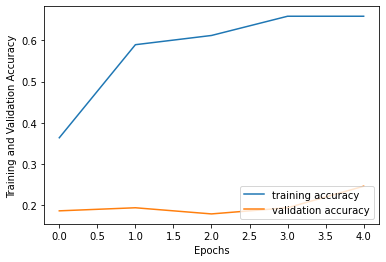

In [29]:
plt.plot(history1.history['accuracy'], label='training accuracy')
plt.plot(history1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

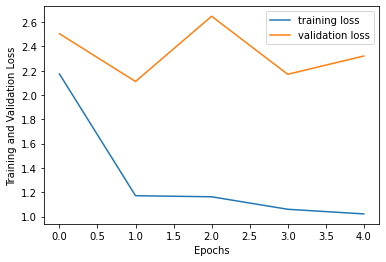

In [30]:
plt.plot(history1.history['loss'], label='training loss')
plt.plot(history1.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

In [27]:
#second cycle

for layer in base_model.layers[len(base_model.layers)//2:]:
    layer.trainable = True

optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [28]:
history2 = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=[checkpoint])

Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.7052 
Epoch 1: val_loss improved from 2.11176 to 2.10266, saving model to ./weights.hdf5
17/17 [==============================] - 282s 17s/step - loss: 0.9240 - accuracy: 0.7052 - val_loss: 2.1027 - val_accuracy: 0.3881
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.5914 - accuracy: 0.8134 
Epoch 2: val_loss did not improve from 2.10266
17/17 [==============================] - 273s 16s/step - loss: 0.5914 - accuracy: 0.8134 - val_loss: 3.0035 - val_accuracy: 0.3433
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.4818 - accuracy: 0.8153 
Epoch 3: val_loss did not improve from 2.10266
17/17 [==============================] - 251s 15s/step - loss: 0.4818 - accuracy: 0.8153 - val_loss: 3.4409 - val_accuracy: 0.2612
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.4170 - accuracy: 0.8601 
Epoch 4: val_loss did not improve from 2.10266
17/

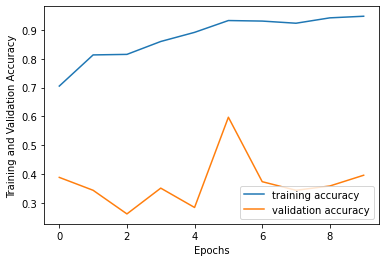

In [31]:
plt.plot(history2.history['accuracy'], label='training accuracy')
plt.plot(history2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

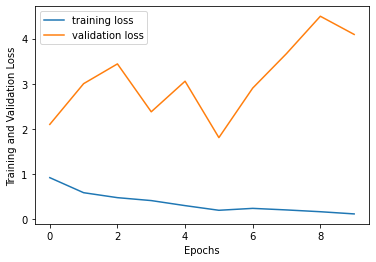

In [32]:
plt.plot(history2.history['loss'], label='training loss')
plt.plot(history2.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

The model clearly started overfitting after after couple of epochs so the best weights saved in the weigh.hdf5 file will be loaded before the third cycle.

In [33]:
model.load_weights('./weights.hdf5')

In [34]:
# third cycle

for layer in base_model.layers:
    layer.trainable = True

optimizer = SGD(learning_rate=0.01, momentum=0.9, decay=0.001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [35]:
history3 = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/100
17/17 [==============================] - ETA: 0s - loss: 0.2455 - accuracy: 0.9086 
Epoch 1: val_loss did not improve from 1.80999
17/17 [==============================] - 454s 26s/step - loss: 0.2455 - accuracy: 0.9086 - val_loss: 3.9880 - val_accuracy: 0.2388
Epoch 2/100
17/17 [==============================] - ETA: 0s - loss: 0.2566 - accuracy: 0.9198 
Epoch 2: val_loss did not improve from 1.80999
17/17 [==============================] - 451s 27s/step - loss: 0.2566 - accuracy: 0.9198 - val_loss: 3.2764 - val_accuracy: 0.2612
Epoch 3/100
17/17 [==============================] - ETA: 0s - loss: 0.1879 - accuracy: 0.9496 
Epoch 3: val_loss did not improve from 1.80999
17/17 [==============================] - 455s 27s/step - loss: 0.1879 - accuracy: 0.9496 - val_loss: 4.1852 - val_accuracy: 0.2985
Epoch 4/100
17/17 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9328 
Epoch 4: val_loss did not improve from 1.80999
17/17 [============================

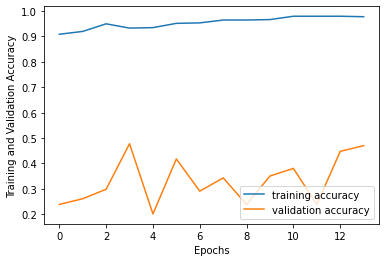

In [36]:
plt.plot(history3.history['accuracy'], label='training accuracy')
plt.plot(history3.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Accuracy')
plt.legend(loc='lower right')

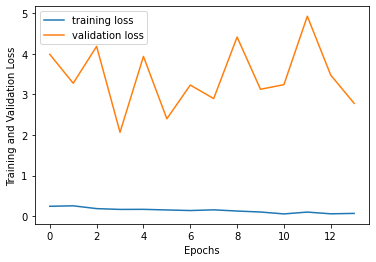

In [37]:
plt.plot(history3.history['loss'], label='training loss')
plt.plot(history3.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Training and Validation Loss')
plt.legend()

The model performance did not improve at all so we will return to the best weights reached in the second cycle.

In [39]:
# loading the testset

test_images_files_names = os.listdir('/content/Images')
test_set = pd.DataFrame(test_images_files_names, columns=['id'])
test_set.head()

,id
0,06_113.png
1,04_012.png
2,06_046.png
3,04_001.png
4,03_052.png


In [41]:
test_data_generator = ImageDataGenerator(rescale= 1./255)
test_generator = test_data_generator.flow_from_dataframe(test_set, directory='/content/Images', x_col='id',target_size=SIZE, class_mode=None, batch_size=BATCH_SIZE, shuffle=False)

Found 670 validated image filenames.


In [42]:
model.load_weights('./weights.hdf5')

In [44]:
y_prop = model.predict(test_generator)

In [46]:
results = pd.DataFrame(columns=["id"] + [*train_generator.class_indices.keys()])
results

,id,Akhal-Teke,Appaloosa,Arabian,Friesian,Orlov Trotter,Percheron,Vladimir Heavy Draft


In [47]:
results["id"] = [os.path.splitext(file)[0] for file in os.listdir('/content/Images')]
results.head()

,id,Akhal-Teke,Appaloosa,Arabian,Friesian,Orlov Trotter,Percheron,Vladimir Heavy Draft
0,06_113,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04_012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06_046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03_052,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
results[[*train_generator.class_indices.keys()]] = y_prop
results.head()

results.to_csv("results.csv",index=False)